# Classify Song Genres from Audio Data

We'll be use the data compiled by a research group known as The Echo Nest.  These are two different files which are in different formats - CSV and JSON. One with metadata about tracks alongside the track metrics and another dataset that has musical features of each track such as **danceability** and **acousticness** on a scale from -1 to 1. 

Our goal is to look through this dataset and classify songs as being either 'Hip-Hop' or 'Rock'  with some simple machine learning algorithms such as decision trees and logistic regression.

# 0. Import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

# 1. Overview

In [4]:
tracks = pd.read_csv('fma-rock-vs-hiphop.csv')
echonest_metrics = pd.read_json('echonest-metrics.json', precise_float = True)

In [7]:
tracks.head()

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]",...,NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
1,136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]",...,NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky
2,151,192000,0,NaN,2008-11-26 01:44:55,NaN,192,0,Rock,[25],...,NaN,701,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,148,NaN,4,NaN,[],Untitled 04
3,152,192000,0,NaN,2008-11-26 01:44:58,NaN,193,0,Rock,[25],...,NaN,637,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,98,NaN,11,NaN,[],Untitled 11
4,153,256000,0,Arc and Sender,2008-11-26 01:45:00,2008-11-26 00:00:00,405,5,Rock,[26],...,NaN,354,en,Attribution-NonCommercial-NoDerivatives (aka M...,424,NaN,2,NaN,[],Hundred-Year Flood


In [8]:
echonest_metrics.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


In [9]:
echo_tracks = echonest_metrics.merge(tracks[['track_id', 'genre_top']], on = 'track_id')

In [10]:
echo_tracks.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


In [5]:
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


To keep the model simple and improve interpretability we want to avoid using variables that have strong correlations with each other (feature redundancy) also  when our datasets are very large, using fewer features can drastically speed up our computation time.

Let's see if there are any strongly correlated features in our data using pandas.

In [11]:
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


We can't see any particularly strong correlations between our features. So let's continue spliting our data and perform some preprocessing steps to optimize our model development.

# 2. Preparing data

How we didn't find any particular strong correlations between our features, we can try to reduce the number of features with the called **principal component analysis (PCA)**.

It is possible that the variance between genres can be explained by just a few features in the dataset. PCA rotates the data along the axis of highest variance, thus allowing us to determine the relative contribution of each feature of our data towards the variance between classes.

However, since PCA uses the absolute variance of a feature to rotate the data, a feature with a broader range of values will overpower and bias the algorithm relative to the other features. To avoid this, we must first normalize our train and test features. A common way is through standardization, such that all features have a $\mu$ = 0 and $\sigma$ = 1 (the resultant is a z-score).

### Splitting data

In [12]:
features = echo_tracks.drop(['track_id','genre_top'], axis = 1).values
labels = echo_tracks['genre_top'].values

train_features, test_features, train_labels, test_labels = train_test_split(features,labels,random_state = 10)

### Normalizing the feature data

In [13]:
scaler = StandardScaler()

scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

### PCA on the scaled data

We are going to use scree-plots to find the number of components to use in further analyses.

Text(0.5, 0, 'Principal Component #')

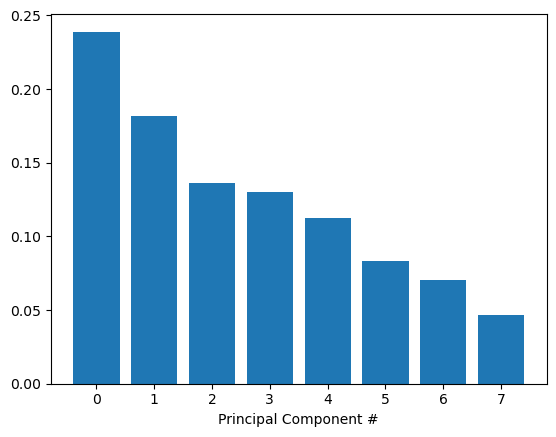

In [14]:
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

Unfortunately, there does not appear to be a clear elbow in this scree plot, which means it is not straightforward to find the number of intrinsic dimensions using this method.

Instead, we can also look at the cumulative explained variance plot to determine how many features are required to explain the most of the variance (say about 85%). Once we determine the appropriate number of components, we can perform PCA with that many components, ideally reducing the dimensionality of our data.

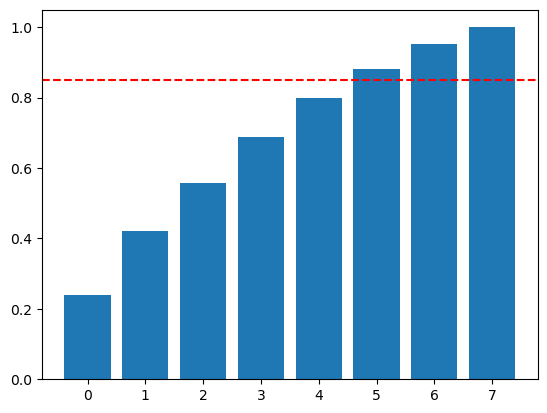

In [16]:
cum_exp_variance = exp_variance.cumsum()

fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), cum_exp_variance)
ax.axhline(y = 0.85, linestyle = '--', color = 'r')

We can see from the plot that 6 (index starts at 0) features can explain 85% of the variance. Therefore, we can use 6 components to perform PCA and reduce the dimensionality of our train and test features.

In [17]:
pca = PCA(n_components = 6, random_state = 10)
 
train_pca = pca.fit_transform(scaled_train_features)
test_pca = pca.transform(scaled_test_features)

# 3. Testing the model

### Decision tree vs logistic regression

In [19]:
tree = DecisionTreeClassifier(random_state = 10)
tree.fit(train_pca, train_labels)
pred_labels_tree = tree.predict(test_pca)

logreg = LogisticRegression(random_state = 10)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

class_rep_tree = classification_report(test_labels,pred_labels_tree)
class_rep_log = classification_report(test_labels,pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.63      0.62      0.62       235
        Rock       0.91      0.91      0.91       966

    accuracy                           0.85      1201
   macro avg       0.77      0.77      0.77      1201
weighted avg       0.85      0.85      0.85      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



Both our models do similarly, boasting an average precision around of 77% each. However, looking at our classification report, we can see that rock songs are fairly well classified, but hip-hop songs are disproportionately misclassified as rock songs. 

This is because our data is unbalanced, we have far more data points for the rock classification than for hip-hop, potentially skewing our model's ability to distinguish between classes. In fact most of our model's accuracy is driven by its ability to classify just rock songs, which is less than ideal.

# 4. Balancing the data

We can weight the value of a correct classification in each class inversely to the occurrence of data points for each class. Since a correct classification for "Rock" is not more important than a correct classification for "Hip-Hop" (and vice versa), we only need to account for differences in sample size of our data points when weighting our classes here, and not relative importance of each class.

In [20]:
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']

rock_only = rock_only.sample(hop_only.shape[0], random_state = 10)

rock_hop_bal = pd.concat([rock_only, hop_only])

features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=10)

train_pca = pca.fit_transform(scaler.fit_transform(train_features))
test_pca = pca.transform(scaler.transform(test_features))

### Second test

In [25]:
tree = DecisionTreeClassifier(random_state = 10)
tree.fit(train_pca, train_labels)
pred_labels_tree = tree.predict(test_pca)

logreg = LogisticRegression(random_state = 10)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.82      0.77      0.79       230
        Rock       0.78      0.82      0.80       225

    accuracy                           0.80       455
   macro avg       0.80      0.80      0.80       455
weighted avg       0.80      0.80      0.80       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       230
        Rock       0.81      0.85      0.83       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.83      0.82      0.82       455



Balancing our data has removed bias towards the more prevalent class. However we need to take into acount that we have reached this position removing a lot of data points that might have been crucial to training our models.

# 5. Cross-validation to evaluate our models

To get a good sense of how well our models are actually performing, we can apply a cross-validation (CV), in particular K-fold CV. This step allows us to compare models in a more rigorous fashion.

But first we will need to create pipelines to scale our data, perform PCA, and instantiate our model of choice - DecisionTreeClassifier or LogisticRegression.

In [27]:
tree_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components = 6)), 
                      ("tree", DecisionTreeClassifier(random_state = 10))])
logreg_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components = 6)), 
                        ("logreg", LogisticRegression(random_state = 10))])

kf = KFold(10)

tree_score = cross_val_score(tree_pipe,train_pca, train_labels, cv = kf)
logit_score = cross_val_score(logreg_pipe,train_pca, train_labels, cv = kf)

print("Decision Tree: %.2f +/- %.2f" % (np.mean(tree_score),np.std(tree_score)))
print("Logistic Regression: %.2f +/- %.2f" % (np.mean(logit_score),np.std(logit_score)))

Decision Tree: 0.79 +/- 0.02
Logistic Regression: 0.83 +/- 0.03


# 5. Conclusion 

We worked with this dataset and manipulate it to classify songs in 'Hip-Hop' or 'Rock' succesufully using a decision tree and a logistic regression model. As we can se in the CV precision both our models boasting an average precision around of 80% each so there is scope for improvement. Let's remember that we cut off part of the data trying to removed bias towards the more prevalent class wich is a good starting point for a better preprocessing analysis considering a more advanced imputation technique.